In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import (nc_tools,viz_tools,bathy_tools,geo_tools,tidetools)
import os
from datetime import datetime, timedelta
import sys
sys.path.append('/ocean/jieliu/research/meopar/salinity_comparison/')
import salinity3_copy
import datetime
import scipy.io as sio
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
paths = {'nowcast': '/data/jieliu/MEOPAR/river-treatment/oct8_10nowcast/',
        'deepenresult': '/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/',
        'reduced_viscosity': '/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/',
         'all_reduced': '/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/'}

In [3]:
def salinity_plot_test(run_date, saline, run_lower, run_upper, path_ssh,t):
    """This function was made to plot ferry 1.5m/average 3m salinity with different cases vs ferry salinity
        and there differences. should consider set up value_mean_4rd as {}"""
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_deep, value_mean_4rd_deep, \
    salinity11, salinity1_2_4, date_str = salinity3_copy.salinity_fxn\
    (saline, run_date, paths['deepenresult'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_nowcast, value_mean_4rd_nowcast, \
    salinity11, salinity1_2_4, date_str = salinity3_copy.salinity_fxn\
    (saline, run_date, paths['nowcast'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_redu, value_mean_4rd_redu, \
    salinity11, salinity1_2_4, date_str = salinity3_copy.salinity_fxn\
    (saline, run_date, paths['reduced_viscosity'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_allredu, value_mean_4rd_allredu, \
    salinity11, salinity1_2_4, date_str = salinity3_copy.salinity_fxn\
    (saline, run_date, paths['all_reduced'],run_lower,run_upper)
    

    fig = plt.figure(figsize=(16,5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    gs.update(wspace=0.17, hspace=0.3)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])

    ## 1.5m salinity comparison
    model_3rd_nowcast=ax0.plot(lon_model,value_mean_3rd_nowcast,'DodgerBlue',\
                                        linewidth=2, label='nowcast')
    model_3rd_deep=ax0.plot(lon_model,value_mean_3rd_deep,'Olive',\
                                            linewidth=2, label="run1" )
    model_3rd_redu=ax0.plot(lon_model,value_mean_3rd_redu,'cyan',\
                                            linewidth=2, label="run2" )
    model_3rd_allredu=ax0.plot(lon_model,value_mean_3rd_allredu,'red',\
                                            linewidth=2, label="run3" )

    observation_salinity=ax0.plot(lon1_model,salinity1_2_4,'DarkGreen', \
                                         linewidth=2, label="Observed")
    titles = '1.5 m Salinity ';
    ax = ax0
    ax.set_xlim(-124, -123)
    ax.set_ylim(10, 32)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Practical Salinity')
    ax.legend(loc = 3)
    ax.grid('on')
    ax.set_title(titles + date_str)

    ## add ssh plot
    ssh,tt, hour = salinity3_copy.get_ssh_in_model(run_date, path_ssh,t)
    ax1.plot(tt[:],ssh[:, 466,329],'-k', linewidth = 2.5)
    ax1.plot(tt[t],ssh[t, 466,329], color = 'Maroon',marker='*', markersize = 14)
    ax1.grid('on')
       
    ax1.set_xlabel('Time [utc]')
    ax1.set_ylabel('Water level (m)')

In [4]:
run_date = datetime.datetime(2014,10,8)
saline=sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE1920141007.mat')

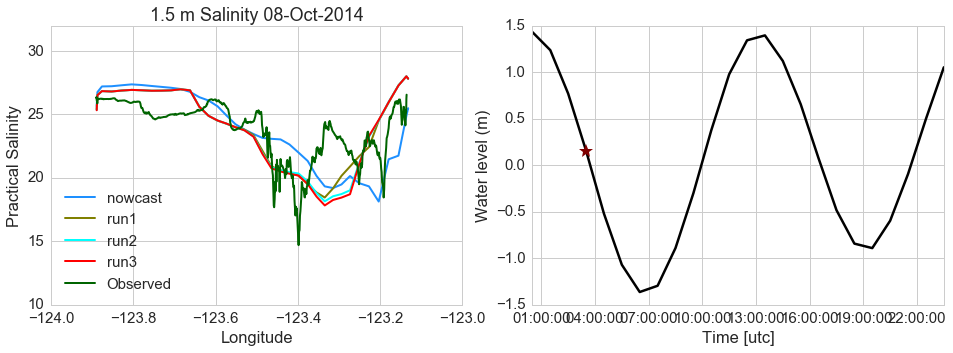

In [5]:
run_lower = run_date.replace(hour = 3, minute = 0)
run_upper = run_date.replace(hour = 5, minute =15)
salinity_plot_test(run_date,saline, run_lower,run_upper,paths['deepenresult'],3)

# statistics

In [6]:
def find_dist (q, lon11, lat11, X, Y, bathy, longitude, latitude, saline_nemo_2rd,\
               saline_nemo_3rd, saline_nemo_4rd,saline_nemo_5rd,results_home):
    k=0
    values_2 =0
    values_3=0
    values_4=0
    values_5=0
    dist = np.zeros(9)
    weights = np.zeros(9)
    value_2rd=np.zeros(9)
    value_3rd=np.zeros(9)
    value_4rd=np.zeros(9)
    value_5rd=np.zeros(9)
    
    x1, j1 = geo_tools.find_closest_model_point(lon11[q],lat11[q],X,Y,land_mask=bathy.mask)
    for i in np.arange(x1-1,x1+2):
         for j in np.arange(j1-1,j1+2):
            dist[k]=geo_tools.haversine(lon11[q],lat11[q],longitude[i,j],latitude[i,j])
            weights[k]=1.0/dist[k]
            value_2rd[k]=saline_nemo_2rd[i,j]*weights[k]
            value_3rd[k]=saline_nemo_3rd[i,j]*weights[k]
            value_4rd[k]=saline_nemo_4rd[i,j]*weights[k]
            value_5rd[k]=saline_nemo_5rd[i,j]*weights[k]
            values_2=values_2+value_2rd[k]
            values_3=values_3+value_3rd[k]
            values_4=values_4+value_4rd[k]
            values_5=values_5+value_5rd[k]
            k+=1
            
    return values_2,values_3,values_4,values_5, weights

In [7]:
def salinity_fxn_norm(saline, run_date, results_home, run_lower, run_upper):
    """The significance of this function was to return longitude,
       latitude, salinity values for observations, 1.5m of 3rd & 4rd, 
       3m average of 3rd & 4rd model result and the time selection for 
       saline_nemo_3rd or 4rd is in the middle """
    a=saline['ferryData']
    b=a['data']
    dataa = b[0,0]
    time=dataa['matlabtime'][0,0]
    lonn=dataa['Longitude'][0,0]
    latt=dataa['Latitude'][0,0]
    salinity=dataa['Practical_Salinity'][0,0]   
    
    a=len(time)
    lon1=np.zeros([a,1])
    lat1=np.zeros([a,1])
    salinity1=np.zeros([a,1])
    time_matlab = []
    for i in np.arange(0,a):
        matlab_datenum = np.float(time[i]);
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366);
        time_matlab.append(python_datetime)
        
        if(python_datetime >= run_lower) &(python_datetime <= run_upper):
            lon1[i]=lonn[i]
            lat1[i]=latt[i]
            salinity1[i]=salinity[i]
            
    mask=lon1[:,0]!=0
    lon1_2_4=lon1[mask]
    lat1_2_4=lat1[mask]
    salinity1_2_4=salinity1[mask]
    time1_2_4 = np.array(time_matlab)[mask]
    lon11=lon1_2_4[0:-1:20]
    lat11=lat1_2_4[0:-1:20]
    salinity11=salinity1_2_4[0:-1:20]
    time11 = time1_2_4[0:-1:20]
    date_str = run_date.strftime('%d-%b-%Y')
    
    if results_home == paths['nowcast']:
        bathyold, X, Y = salinity3_copy.get_SS2_bathy_data()   
    else:
        bathynew6, X, Y = salinity3_copy.get_SS6_bathy_data()


    filepath_name = salinity3_copy.date(run_date.year,run_date.month, run_date.day,\
    run_date.day,run_date.day, results_home,'1h','grid_T') 
    tracers=nc.Dataset(filepath_name[0])

        
    latitude=tracers.variables['nav_lat'][:] 
    longitude=tracers.variables['nav_lon'][:] 
    saline_nemo = tracers.variables['vosaline']

    matrix=np.zeros([len(lon11),9])
    values_2=np.zeros([len(lon11),1])
    values_3=np.zeros([len(lon11),1])
    values_4=np.zeros([len(lon11),1])
    values_5=np.zeros([len(lon11),1])
    value_mean_2rd_hour=np.zeros([len(lon11),1])
    value_mean_3rd_hour=np.zeros([len(lon11),1])
    value_mean_4rd_hour=np.zeros([len(lon11),1])
    value_mean_5rd_hour=np.zeros([len(lon11),1])
    if run_lower.hour ==0 or run_lower.hour ==5 or run_lower.hour == 14 or run_lower.hour == 19 or\
        run_lower.hour ==3 or run_lower.hour ==12 or run_lower.hour ==17 or run_lower.hour ==22:
        if run_lower.hour ==0 or run_lower.hour ==5 or run_lower.hour == 14 or run_lower.hour == 19 : 
            saline_nemo_2rd = saline_nemo[run_lower.hour, 1] 
            saline_nemo_3rd = saline_nemo[run_lower.hour +1,1] 
            saline_nemo_4rd = saline_nemo[run_lower.hour +2 ,1]
            saline_nemo_5rd = saline_nemo[run_lower.hour +3 ,1]
                
        elif run_lower.hour ==3 or run_lower.hour ==12 or run_lower.hour ==17 or run_lower.hour ==22:
            saline_nemo_2rd = saline_nemo[run_lower.hour-1 , 1] 
            saline_nemo_3rd = saline_nemo[run_lower.hour, 1] 
            saline_nemo_4rd = saline_nemo[run_lower.hour +1,  1]
                
            if run_lower.hour ==22 and run_lower.day ==10: ## if lower is 22 pm on Oct 10, after 23:30 still use 23:30 value
                saline_nemo_5rd = np.zeros(saline_nemo[run_lower.hour, 1].shape)
                
            elif run_lower.hour ==22 and run_lower.day !=10:
                filepath_name = salinity3_copy.date(run_date.year,run_date.month, run_date.day+1,\
                run_date.day+1,run_date.day+1, results_home,'1h','grid_T') 
                tracers_forward=nc.Dataset(filepath_name[0])
                saline_nemo_forward = tracers_forward.variables['vosaline']
                saline_nemo_5rd = saline_nemo_forward[0,1]

            else:
                saline_nemo_5rd = saline_nemo[run_lower.hour+2 ,1]


        for q in np.arange(0,len(lon11)):
            if (~np.isnan(lon11[q])) and (~np.isnan(lat11[q])):
                if results_home == paths['nowcast']:
                    #print(lon11[q],lat11[q])
                    values_2[q], values_3[q],values_4[q],values_5[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                        bathyold, longitude, latitude, \
                                        saline_nemo_2rd,saline_nemo_3rd, saline_nemo_4rd,saline_nemo_5rd,results_home)
                    value_mean_2rd_hour[q]=values_2[q]/sum(matrix[q])
                    value_mean_3rd_hour[q]=values_3[q]/sum(matrix[q])
                    value_mean_4rd_hour[q]=values_4[q]/sum(matrix[q])
                    value_mean_5rd_hour[q]=values_5[q]/sum(matrix[q])
                    
                else:
                    values_2[q], values_3[q],values_4[q],values_5[q],matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                                 bathynew6, longitude, latitude,\
                                                saline_nemo_2rd,saline_nemo_3rd, saline_nemo_4rd,saline_nemo_5rd,results_home)
                    value_mean_2rd_hour[q]=values_2[q]/sum(matrix[q])
                    value_mean_3rd_hour[q]=values_3[q]/sum(matrix[q])
                    value_mean_4rd_hour[q]=values_4[q]/sum(matrix[q])
                    value_mean_5rd_hour[q]=values_5[q]/sum(matrix[q])

        #print(value_mean_3rd_hour.shape,value_mean_3rd_hour)
    else:
        value_mean_3rd_hour[:] = np.nan
        value_mean_4rd_hour[:] = np.nan     
    #elif results_home ==paths['widenresult']: ## if subdomain file
        #date_str = run_date.strftime('%d-%b-%Y') 
        #value_mean_3rd_hour, value_mean_4rd_hour= salinity_along_track_bathy6\
        #(results_home,run_date,run_lower,run_upper,lon11,lat11,X,Y,bathynew6)

    return lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean_2rd_hour, value_mean_3rd_hour, \
    value_mean_4rd_hour, value_mean_5rd_hour,\
    salinity11, salinity1_2_4, date_str,time11

In [8]:
def time_interp(value_mean_2rd_deep, value_mean_3rd_deep, \
                value_mean_4rd_deep, value_mean_5rd_deep,time):
    """
    Linear time interpolation between continuous hour model results
    """
    value_final = np.zeros(len(time))
    
    if len(time) !=0: ## important, on June 21 time length is 0
        print(time[0],len(time), np.nansum(value_mean_3rd_deep),value_final.shape)
        if time[0].hour ==0 or time[0].hour == 5 or time[0].hour == 14 or time[0].hour ==19:
            low = time[0].replace(minute = 30)
            mid = low.replace(hour = low.hour+1)
            high = mid.replace(hour = mid.hour+1)
            Hhigh = high.replace(hour = high.hour+1)
        elif time[0].hour ==3 or time[0].hour == 17 or time[0].hour == 22 or time[0].hour == 12:           
            low = time[0].replace(hour = time[0].hour-1, minute = 30)
            mid = low.replace(hour = low.hour+1)
            high = mid.replace(hour = mid.hour+1)
            if time[0].hour == 22:
                Hhigh = high.replace(day = high.day+1,hour = 0)
            else:
                Hhigh = high.replace(hour = high.hour+1)

        for i,j in enumerate(time):
            if (j > low) and (j<mid):
                value_final[i] = (value_mean_2rd_deep[i]/((j-low).seconds/60) + \
                                  value_mean_3rd_deep[i]/((mid-j).seconds/60))/\
                                (1/((j-low).seconds/60)+1/((mid-j).seconds/60))
            elif (j > mid) and (j<high):
                value_final[i] = (value_mean_3rd_deep[i]/((j-mid).seconds/60) + \
                                  value_mean_4rd_deep[i]/((high-j).seconds/60))/\
                                (1/((j-mid).seconds/60)+1/((high-j).seconds/60))
            elif (j > high) and (j<Hhigh):
                if j.day == 10 and j.hour == 23 and j.minute >=30: ## Oct 8, exceed 23:30, use 23:30 value
                    value_final[i] = value_mean_4rd_deep[i]
                else:    
                    value_final[i] = (value_mean_4rd_deep[i]/((j-high).seconds/60) + \
                                  value_mean_5rd_deep[i]/((Hhigh-j).seconds/60))/\
                                (1/((j-high).seconds/60)+1/((Hhigh-j).seconds/60))
            if j == low:
                value_final[i] = value_mean_2rd_deep[i]
            if j == mid:
                value_final[i] = value_mean_3rd_deep[i]
            if j == high:
                value_final[i] = value_mean_4rd_deep[i]
            if j == Hhigh:
                value_final[i] = value_mean_5rd_deep[i]

    return value_final

In [9]:
def find_min_value_location(run_date, results_home, saline, run_lower, run_upper,lon11, lat11,\
                                 lon1_2_4, lat1_2_4, value_final,salinity11, salinity1_2_4,date_str):
    """This function was made to find out the minimum salinity value
       and longitude for observation and time interpolated 1.5m model result."""
    
    ##For observation
    if len(salinity1_2_4) ==0:
        salinity_min_obs = np.nan
        lon_min_obs=np.nan
    else:
        salinity_min_obs = np.nanmin(salinity1_2_4)
        ind_obs = np.nanargmin(salinity1_2_4)
        lon_min_obs = lon1_2_4[ind_obs]
    
    ## For nowcast or new model result with 1.5m depth for 3rd model time 
    ## no length or all nan or all 0, then set to nan
    if (len(value_final) ==0) or (np.nansum(value_final) ==np.nan) or (np.nansum(value_final) ==0):
        
        salinity_min_15 = np.nan
        lon_min_15=np.nan

    else:
        value_final[value_final==0]=np.nan ## 12:15 ferry the first value of model result is always 0
        salinity_min_15 = np.nanmin(value_final)## some cases when part of them are 0
        ## since it is subdomain
        ind_15 = np.nanargmin(value_final)
        lon_min_15 = lon11[ind_15]
    
    return salinity_min_obs, lon_min_obs, salinity_min_15,lon_min_15

In [10]:
def min_salinity_test(results_home):
    """This function was made to plot ferry 1.5m/average 3m salinity with different cases vs ferry salinity
        and there differences. should consider set up value_mean_4rd as {}"""
    days = [7,8,9];sal_min_obs = [np.nan]; lon_obs = [np.nan];sal_min_15 = [np.nan];lon_15=[np.nan];
    for day in days:
        for i in np.arange(24):
            if i < 12:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE192014100%s.mat' %(day))
            elif i>=12 and day!=9:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE192014100%s.mat' %(day+1))
            elif i>=12 and day ==9:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE19201410%s.mat' %(day+1))
            ## read in run_date, run_lower and run_upper for each trip case.
            run_date = datetime.datetime(2014,10,day+1)
            if i == 0 or i ==5 or i==14 or i==19 :
                run_lower = run_date.replace(hour = i, minute = 45)
                if i ==0:
                    run_upper = run_date.replace(hour = 3, minute = 15)
                else:
                    run_upper = run_lower.replace(hour = i+2)                
            elif i == 3 or i==12 or i==17 or i==22:
                run_lower = run_date.replace(hour = i, minute = 15)
                if i == 22:
                    run_upper = run_date.replace(day = day+2,hour = 0, minute = 15)
                else:
                    run_upper = run_lower.replace(hour = i+2)
            if i == 0 or i==3 or i==5 or i ==12 or i ==14 or i==17 or i==19 or i ==22:
                lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_2rd_deep, value_mean_3rd_deep, \
                value_mean_4rd_deep, value_mean_5rd_deep,\
                salinity11, salinity1_2_4, date_str, time_ferry = salinity_fxn_norm\
                (saline, run_date, results_home,run_lower,run_upper)
                
                ## Time interpolation
                value_mean_final = time_interp(value_mean_2rd_deep, value_mean_3rd_deep, \
                value_mean_4rd_deep, value_mean_5rd_deep, time_ferry)
            ## find min salinity value and location along ferry route   
                salinity_min_obs, lon_min_obs, salinity_min_15,\
                lon_min_15 = find_min_value_location\
                (run_date, results_home, saline, run_lower, run_upper,lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_final,salinity11, salinity1_2_4, date_str)
            else: 
                salinity_min_obs= np.nan;lon_min_obs=np.nan;salinity_min_15=np.nan;lon_min_15=np.nan
            ## append the values to a list
            sal_min_obs.append(salinity_min_obs);
            lon_obs.append(lon_min_obs);
            sal_min_15.append(salinity_min_15);
            lon_15.append(lon_min_15);
    ##define t
    file = nc.Dataset(results_home+'SalishSea_1h_20141008_20141010_grid_T.nc')
    timesteps = file.variables['time_counter'][:]
    t_t = nc_tools.timestamp(file, np.arange(len(timesteps)))
    for ind in range(len(t_t)):
        t_t[ind] = t_t[ind].datetime
    tt = np.array(t_t)         
    return sal_min_obs, lon_obs, sal_min_15,lon_15,tt   

In [11]:
## nowcast case
sal_min_obs,lon_obs,sal_now,lon_now,tt = min_salinity_test(paths['nowcast'])

2014-10-08 00:45:05.015996 45 1134.70284253 (45,)
2014-10-08 03:15:05.169985 36 858.169842905 (36,)
2014-10-08 05:45:05.317999 35 863.976222887 (35,)
2014-10-08 12:21:55.732996 34 793.728905041 (34,)
2014-10-08 14:45:05.849992 36 877.282447801 (36,)
2014-10-08 17:15:05.999998 36 874.320562891 (36,)
2014-10-08 19:45:06.141997 36 899.026164814 (36,)
2014-10-08 22:15:06.288996 36 920.589478072 (36,)
2014-10-09 00:45:06.447994 45 1147.48746066 (45,)
2014-10-09 03:15:06.578999 36 891.636535594 (36,)
2014-10-09 05:45:06.734990 33 827.213911177 (33,)
2014-10-09 12:19:07.148002 35 847.601233982 (35,)
2014-10-09 14:45:07.265997 36 920.899534871 (36,)
2014-10-09 17:15:07.813999 36 905.594482145 (36,)
2014-10-09 19:45:07.552993 36 922.445861342 (36,)
2014-10-09 22:15:07.700998 36 922.954499937 (36,)
2014-10-10 00:45:07.843993 45 1181.62856488 (45,)
2014-10-10 03:15:07.996000 36 909.779781202 (36,)
2014-10-10 05:45:08.143995 33 821.799737777 (33,)
2014-10-10 12:34:28.570001 31 749.175653588 (31,)


In [12]:
## reduce viscosity
sal_min_obs,lon_obs,sal_redu,lon_redu,tt = min_salinity_test(paths['reduced_viscosity'])

2014-10-08 00:45:05.015996 45 1141.83075462 (45,)
2014-10-08 03:15:05.169985 36 860.164706433 (36,)
2014-10-08 05:45:05.317999 35 851.940274561 (35,)
2014-10-08 12:21:55.732996 34 785.132484279 (34,)
2014-10-08 14:45:05.849992 36 868.67020534 (36,)
2014-10-08 17:15:05.999998 36 866.087160715 (36,)
2014-10-08 19:45:06.141997 36 889.295388983 (36,)
2014-10-08 22:15:06.288996 36 912.054363003 (36,)
2014-10-09 00:45:06.447994 45 1149.98396161 (45,)
2014-10-09 03:15:06.578999 36 911.758190243 (36,)
2014-10-09 05:45:06.734990 33 827.339887945 (33,)
2014-10-09 12:19:07.148002 35 845.901392987 (35,)
2014-10-09 14:45:07.265997 36 918.226448886 (36,)
2014-10-09 17:15:07.813999 36 911.644248393 (36,)
2014-10-09 19:45:07.552993 36 922.909566485 (36,)
2014-10-09 22:15:07.700998 36 928.850541261 (36,)
2014-10-10 00:45:07.843993 45 1174.10317311 (45,)
2014-10-10 03:15:07.996000 36 931.189423716 (36,)
2014-10-10 05:45:08.143995 33 841.387612209 (33,)
2014-10-10 12:34:28.570001 31 748.327679712 (31,)
2

In [13]:
## reduce both
sal_min_obs,lon_obs,sal_allredu,lon_allredu,tt = min_salinity_test(paths['all_reduced'])

2014-10-08 00:45:05.015996 45 1140.85565231 (45,)
2014-10-08 03:15:05.169985 36 857.909687482 (36,)
2014-10-08 05:45:05.317999 35 848.922423201 (35,)
2014-10-08 12:21:55.732996 34 780.21691316 (34,)
2014-10-08 14:45:05.849992 36 863.200670037 (36,)
2014-10-08 17:15:05.999998 36 859.421691318 (36,)
2014-10-08 19:45:06.141997 36 884.051956155 (36,)
2014-10-08 22:15:06.288996 36 908.1547917 (36,)
2014-10-09 00:45:06.447994 45 1144.19661752 (45,)
2014-10-09 03:15:06.578999 36 908.879619309 (36,)
2014-10-09 05:45:06.734990 33 823.004293187 (33,)
2014-10-09 12:19:07.148002 35 842.007118778 (35,)
2014-10-09 14:45:07.265997 36 915.841628154 (36,)
2014-10-09 17:15:07.813999 36 909.029318616 (36,)
2014-10-09 19:45:07.552993 36 920.639480676 (36,)
2014-10-09 22:15:07.700998 36 924.166732348 (36,)
2014-10-10 00:45:07.843993 45 1169.24622056 (45,)
2014-10-10 03:15:07.996000 36 928.103784012 (36,)
2014-10-10 05:45:08.143995 33 835.78899182 (33,)
2014-10-10 12:34:28.570001 31 743.885140373 (31,)
2014

In [14]:
## only long river case
sal_min_obs,lon_obs,sal_deep,lon_deep,tt = min_salinity_test(paths['deepenresult'])

2014-10-08 00:45:05.015996 45 1141.71840723 (45,)
2014-10-08 03:15:05.169985 36 864.980817309 (36,)
2014-10-08 05:45:05.317999 35 849.770454348 (35,)
2014-10-08 12:21:55.732996 34 788.76173595 (34,)
2014-10-08 14:45:05.849992 36 868.972862527 (36,)
2014-10-08 17:15:05.999998 36 861.104629439 (36,)
2014-10-08 19:45:06.141997 36 888.560965582 (36,)
2014-10-08 22:15:06.288996 36 910.315816796 (36,)
2014-10-09 00:45:06.447994 45 1142.91862831 (45,)
2014-10-09 03:15:06.578999 36 904.935079919 (36,)
2014-10-09 05:45:06.734990 33 822.792619961 (33,)
2014-10-09 12:19:07.148002 35 839.789894242 (35,)
2014-10-09 14:45:07.265997 36 916.408113707 (36,)
2014-10-09 17:15:07.813999 36 908.403175799 (36,)
2014-10-09 19:45:07.552993 36 919.64125219 (36,)
2014-10-09 22:15:07.700998 36 921.843721119 (36,)
2014-10-10 00:45:07.843993 45 1163.56342053 (45,)
2014-10-10 03:15:07.996000 36 920.810509965 (36,)
2014-10-10 05:45:08.143995 33 833.198038372 (33,)
2014-10-10 12:34:28.570001 31 749.642838327 (31,)
20

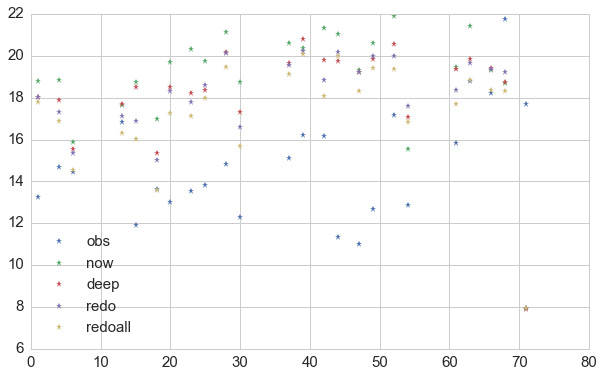

In [15]:
## test values
fig, ax = plt.subplots(1,1,figsize = (10,6))
ax.plot(sal_min_obs,'*',label = 'obs')
ax.plot(sal_now,'*',label = 'now')
ax.plot(sal_deep,'*',label = 'deep')
ax.plot(sal_redu,'*',label = 'redo')
ax.plot(sal_allredu,'*',label ='redoall')
ax.legend(loc = 'best')

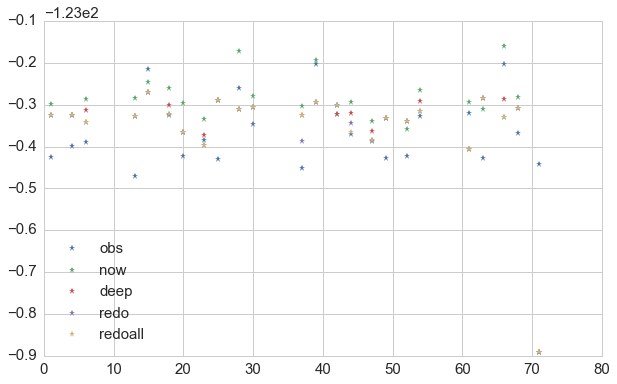

In [16]:
## test locs
fig, ax = plt.subplots(1,1,figsize = (10,6))
ax.plot(lon_obs,'*',label = 'obs')
ax.plot(lon_now,'*',label = 'now')
ax.plot(lon_deep,'*',label = 'deep')
ax.plot(lon_redu,'*',label = 'redo')
ax.plot(lon_allredu,'*',label ='redoall')
ax.legend(loc = 'best')

In [17]:
## get rid of the last time value and loc, not reasonable
sal_min_obs[-2] = np.nan
sal_now[-2] = np.nan
sal_deep[-2] = np.nan
sal_redu[-2] = np.nan
sal_allredu[-2] = np.nan
## loc
lon_obs[-2] = np.nan
lon_now[-2] = np.nan
lon_redu[-2] = np.nan
lon_allredu[-2] = np.nan

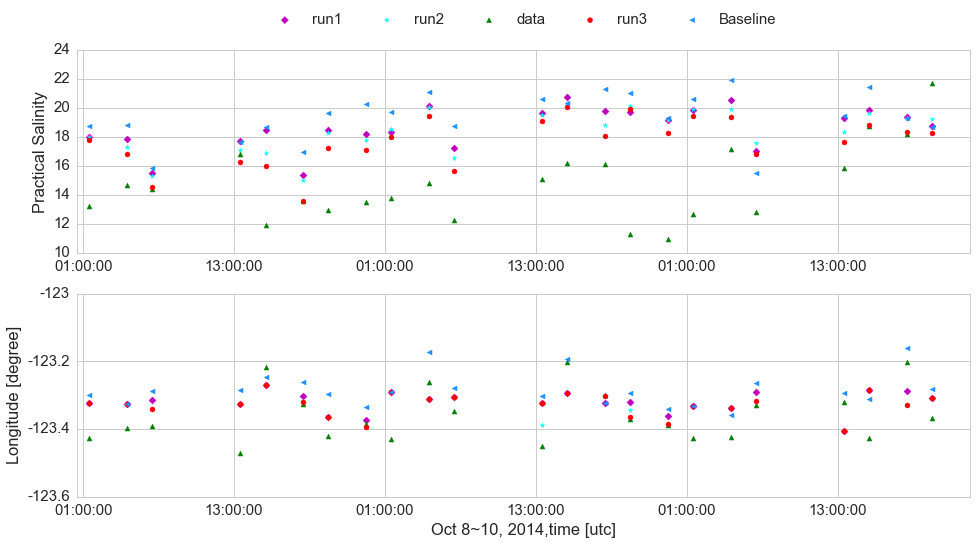

In [18]:
s = 26
fig, axs = plt.subplots(2,1,figsize = [16,8])
axs[0].scatter(tt,sal_deep[:-1],color = 'm',marker ='D',label = 'run1',s = s)
axs[0].scatter(tt,sal_redu[:-1],color = 'cyan',marker ='*',label = 'run2',s = s)
axs[0].scatter(tt,sal_min_obs[:-1],color = 'green',marker ='^',label = 'data',s = s)
axs[0].scatter(tt,sal_allredu[:-1],color = 'red',marker ='o',label = 'run3',s=s)
axs[0].scatter(tt,sal_now[:-1],color = 'DodgerBlue',marker='<',label = 'Baseline',s = s)
axs[0].set_ylabel('Practical Salinity')

axs[1].scatter(tt,lon_deep[:-1],color = 'm',marker ='D',label = 'run1',s = s)
axs[1].scatter(tt,lon_redu[:-1],color = 'cyan',marker ='*',label = 'run2',s = s)
axs[1].scatter(tt,lon_obs[:-1],color = 'green',marker ='^',label = 'data',s = s)
axs[1].scatter(tt,lon_allredu[:-1],color = 'red',marker ='o',label = 'run3',s=s)
axs[1].scatter(tt,lon_now[:-1],color = 'DodgerBlue',marker='<',label = 'Baseline',s = s)
axs[1].set_ylabel('Longitude [degree]')
axs[1].set_ylim(-123.6, -123)
axs[1].set_yticks([-123.6, -123.4, -123.2,-123])
axs[1].set_yticklabels([-123.6, -123.4, -123.2,-123])
axs[1].set_xlabel('Oct 8~10, 2014,time [utc]')
for ax in axs:
    #ax.legend(loc = 'best', fontsize= 14)   
    ax.set_xlim(tt[0],tt[-1])
    ax.grid('on')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=5, fancybox=False, shadow=True)

* bias

In [19]:
## value
diff_sal_now = np.nanmean(np.array(sal_now)-np.array(sal_min_obs))
diff_sal_deep = np.nanmean(np.array(sal_deep)-np.array(sal_min_obs))
diff_sal_redu = np.nanmean(np.array(sal_redu)-np.array(sal_min_obs))
diff_sal_allredu = np.nanmean(np.array(sal_allredu)-np.array(sal_min_obs))
## std
std_sal_now = np.nanstd(np.array(sal_now)-np.array(sal_min_obs))
std_sal_deep = np.nanstd(np.array(sal_deep)-np.array(sal_min_obs))
std_sal_redu = np.nanstd(np.array(sal_redu)-np.array(sal_min_obs))
std_sal_allredu = np.nanstd(np.array(sal_allredu)-np.array(sal_min_obs))

In [20]:
## loc
diff_sal_now_loc = np.nanmean(np.array(lon_now)-np.array(lon_obs))
diff_sal_deep_loc = np.nanmean(np.array(lon_deep)-np.array(lon_obs))
diff_sal_redu_loc = np.nanmean(np.array(lon_redu)-np.array(lon_obs))
diff_sal_allredu_loc = np.nanmean(np.array(lon_allredu)-np.array(lon_obs))
## std
std_sal_now_loc = np.nanstd(np.array(lon_now)-np.array(lon_obs))
std_sal_deep_loc = np.nanstd(np.array(lon_deep)-np.array(lon_obs))
std_sal_redu_loc = np.nanstd(np.array(lon_redu)-np.array(lon_obs))
std_sal_allredu_loc = np.nanstd(np.array(lon_allredu)-np.array(lon_obs))

In [21]:
## Standard error = Standard deviation/np.sqrt(n), n is the sample number
print('Standard error for nowcast in salinity:', std_sal_now/np.sqrt(23))
print('Standard error for deeper river channel in salinity:',std_sal_deep/np.sqrt(23))
print('Standard error for reduced visocsity in salinity:',std_sal_redu/np.sqrt(23))
print('Standard error for reduced both viscosity and diffusivity in salinity:',std_sal_allredu/np.sqrt(23))

Standard error for nowcast in salinity: 0.58493032156
Standard error for deeper river channel in salinity: 0.535186864055
Standard error for reduced visocsity in salinity: 0.539632699291
Standard error for reduced both viscosity and diffusivity in salinity: 0.566504043914


In [22]:
print('Standard error for nowcast in location:', std_sal_now_loc/np.sqrt(23))
print('Standard error for deeper river channel in location:',std_sal_deep_loc/np.sqrt(23))
print('Standard error for reduced visocsity in location:',std_sal_redu_loc/np.sqrt(23))
print('Standard error for reduced both viscosity and diffusivity in location:',std_sal_allredu_loc/np.sqrt(23))

Standard error for nowcast in location: 0.0107382934427
Standard error for deeper river channel in location: 0.0151948183934
Standard error for reduced visocsity in location: 0.015454634456
Standard error for reduced both viscosity and diffusivity in location: 0.0159985302663


In [ ]:
print(stdError_sal_now,stdError_sal_deep,stdError_sal_redu)

In [23]:
## standard error for salinity value
stdError_sal_now = std_sal_now/np.sqrt(23)
stdError_sal_deep = std_sal_deep/np.sqrt(23)
stdError_sal_redu = std_sal_redu/np.sqrt(23)
stdError_sal_allredu = std_sal_allredu/np.sqrt(23)

In [24]:
## standard error for loc
stdError_sal_now_loc = std_sal_now_loc/np.sqrt(23)
stdError_sal_deep_loc = std_sal_deep_loc/np.sqrt(23)
stdError_sal_redu_loc = std_sal_redu_loc/np.sqrt(23)
stdError_sal_allredu_loc = std_sal_allredu_loc/np.sqrt(23)

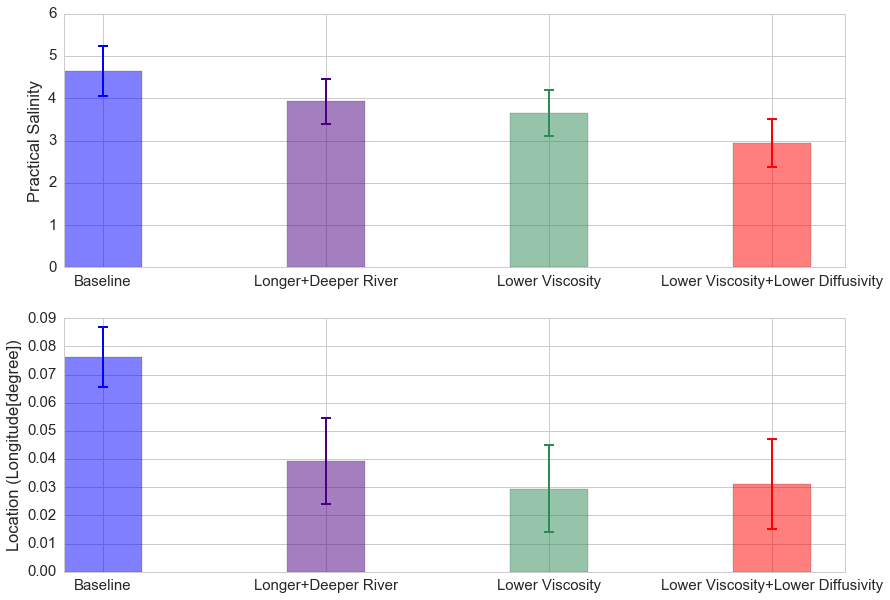

In [25]:
fig, axs = plt.subplots(2,1,figsize = [14,10])
diff_values = [diff_sal_now,diff_sal_deep,diff_sal_redu,diff_sal_allredu]
ind = np.arange(len(diff_values))
colors = ['b','Indigo','SeaGreen','r']
std_Errors = [stdError_sal_now,stdError_sal_deep,stdError_sal_redu,stdError_sal_allredu]
diff_locs = [diff_sal_now_loc,diff_sal_deep_loc,diff_sal_redu_loc,diff_sal_allredu_loc]
std_locsErrors = [stdError_sal_now_loc,stdError_sal_deep_loc,stdError_sal_redu_loc,stdError_sal_allredu_loc]
width = 0.35
ax = axs[0] ## diff values
diff_value = ax.bar(ind, diff_values, width,color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, diff_values, std_Errors, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Practical Salinity')

ax =axs[1] ## diff locations
diff_loc = ax.bar(ind, diff_locs, width, color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, diff_locs, std_locsErrors, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Location (Longitude[degree])')
## xlabels
for ax in axs:
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(('Baseline', 'Longer+Deeper River','Lower Viscosity', \
                      'Lower Viscosity+Lower Diffusivity' ))

* RMS

In [24]:
## value
diff_sal_now = np.sqrt(np.nansum((np.array(sal_now)-np.array(sal_min_obs))**2)/23)
diff_sal_deep = np.sqrt(np.nansum((np.array(sal_deep)-np.array(sal_min_obs))**2)/23)
diff_sal_redu = np.sqrt(np.nansum((np.array(sal_redu)-np.array(sal_min_obs))**2)/23)
diff_sal_allredu = np.sqrt(np.nansum((np.array(sal_allredu)-np.array(sal_min_obs))**2)/23)
## std
std_sal_now = np.nanstd(np.sqrt((np.array(sal_now)-np.array(sal_min_obs))**2))
std_sal_deep = np.nanstd(np.sqrt((np.array(sal_deep)-np.array(sal_min_obs))**2))
std_sal_redu = np.nanstd(np.sqrt((np.array(sal_redu)-np.array(sal_min_obs))**2))
std_sal_allredu = np.nanstd(np.sqrt((np.array(sal_allredu)-np.array(sal_min_obs))**2))

In [25]:
## loc
diff_sal_now_loc = np.sqrt(np.nansum((np.array(lon_now)-np.array(lon_obs))**2)/23)
diff_sal_deep_loc = np.sqrt(np.nansum((np.array(lon_deep)-np.array(lon_obs))**2)/23)
diff_sal_redu_loc = np.sqrt(np.nansum((np.array(lon_redu)-np.array(lon_obs))**2)/23)
diff_sal_allredu_loc = np.sqrt(np.nansum((np.array(lon_allredu)-np.array(lon_obs))**2)/23)
## std
std_sal_now_loc = np.nanstd(np.sqrt((np.array(lon_now)-np.array(lon_obs))**2))
std_sal_deep_loc = np.nanstd(np.sqrt((np.array(lon_deep)-np.array(lon_obs))**2))
std_sal_redu_loc = np.nanstd(np.sqrt((np.array(lon_redu)-np.array(lon_obs))**2))
std_sal_allredu_loc = np.nanstd(np.sqrt((np.array(lon_allredu)-np.array(lon_obs))**2))

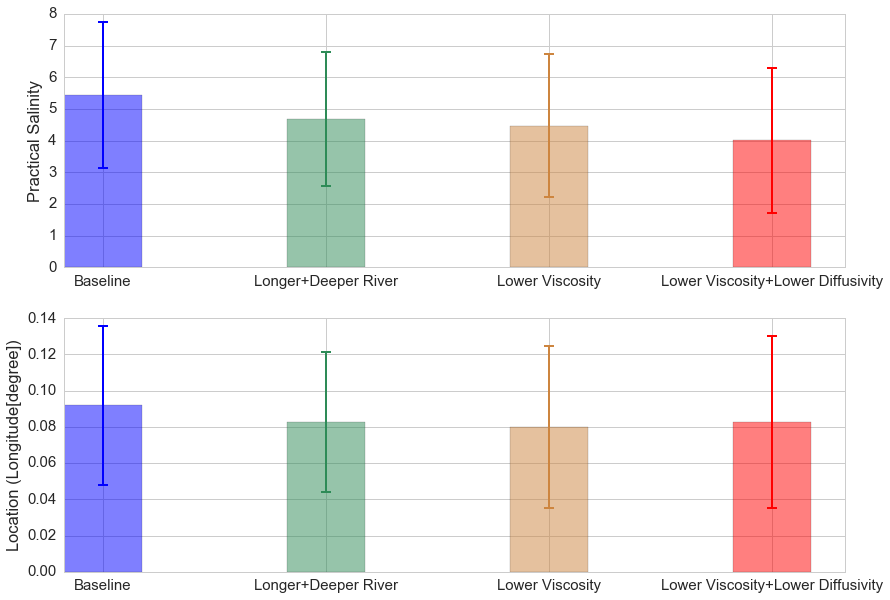

In [26]:
fig, axs = plt.subplots(2,1,figsize = [14,10])
diff_values = [diff_sal_now,diff_sal_deep,diff_sal_redu,diff_sal_allredu]
ind = np.arange(len(diff_values))
colors = ['b','SeaGreen','Peru','r']
std_values = [std_sal_now,std_sal_deep,std_sal_redu,std_sal_allredu]
diff_locs = [diff_sal_now_loc,diff_sal_deep_loc,diff_sal_redu_loc,diff_sal_allredu_loc]
std_locs = [std_sal_now_loc,std_sal_deep_loc,std_sal_redu_loc,std_sal_allredu_loc]
width = 0.35
ax = axs[0] ## diff values
diff_value = ax.bar(ind, diff_values, width,color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, diff_values, std_values, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Practical Salinity')

ax =axs[1] ## diff locations
diff_loc = ax.bar(ind, diff_locs, width, color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, diff_locs, std_locs, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Location (Longitude[degree])')
## xlabels
for ax in axs:
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(('Baseline', 'Longer+Deeper River','Lower Viscosity', \
                      'Lower Viscosity+Lower Diffusivity' ))

In [27]:
SITES = {
    'VENUS East':{
        'lat' : 49.0419,
        'lon' : -123.3176,
        'depth' : 170,
        'i' : 416,
        'j' : 283
    },    
    'VENUS Central': {
        'lat': 49.0401,
        'lon': -123.4261,
        'depth' : 300,
        'i': 424,
        'j': 266
        },
        }

In [28]:
runs=['oct8_101e061e05','oct8_10test1e-04']
base='/data/jieliu/MEOPAR/river-treatment/'
sals={}; depths={}; avms={}; avds={}; Ws={};depthws={}; Us={}; Vs={}
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
bathy=grid.variables['Bathymetry']
for run in runs:
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_T.nc'.format(run))
    f = nc.Dataset(path,'r');
    sals[run]=f.variables['vosaline']
    depths[run] = f.variables['deptht'] 
    T_lat = f.variables['nav_lat']
    T_lon = f.variables['nav_lon']

    #Loading eddy viscosity/diffusivity data on the vertical grid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_W.nc'.format(run))
    f = nc.Dataset(path,'r');
    avms[run]=f.variables['ve_eddy_visc']
    avds[run]= f.variables['ve_eddy_diff'] #
    Ws[run]=f.variables['vovecrtz']
    depthws[run] = f.variables['depthw']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_U.nc'.format(run))
    f = nc.Dataset(path,'r');
    Us[run]=f.variables['vozocrtx']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_V.nc'.format(run))
    f = nc.Dataset(path,'r');
    Vs[run]=f.variables['vomecrty']

In [29]:
def compare_visc_diff(j, i,station,zmin=0, zmax=50, xmin=-7,xmax=-2):
    """Compare vertical eddy diff and viscosity at time t and gridpoint (i,j)"""
    
    colors=['b','g']
    strings = ['LowerBoth','HigherBoth']
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    for run, c in zip(runs, colors):
        #diff
        title = ' Diffusivity averaged over 3 days - {}'.format( station )
        ax=axs[0]
        avd=avds[run][:,:,j,i]
        avd=np.nanmean(np.ma.masked_values(avd,0),axis=0)
        if run ==runs[0]:
            ax.plot(np.log10(avd),depthws[run],'-o',label=strings[0],color=c)
        elif run ==runs[1]:
            ax.plot(np.log10(avd),depthws[run],'-o',label=strings[1],color=c)
        ax.plot(np.log10([bg[run]['diff'], bg[run]['diff']]), [depthws[run][0], depthws[run][-1]],
                '--', color=c, label='background')
        ax.set_xlabel('Log base 10 of Diffusivity $\mathrm{(m^2s^{-1})}$')
        
        #visc
        title = ' Viscosity averaged over 3 days - {}'.format(station )
        ax=axs[1]
        avm=avms[run][:,:,j,i]
        avm=np.nanmean(np.ma.masked_values(avm,0),axis=0)
        if run ==runs[0]:
            ax.plot(np.log10(avm),depthws[run],'-o',label=strings[0],color=c)
        elif run ==runs[1]:
            ax.plot(np.log10(avm),depthws[run],'-o',label=strings[1],color=c)
        ax.plot(np.log10([bg[run]['visc'], bg[run]['visc']]), [depthws[run][0], depthws[run][-1]],
                '--', color=c, label='background')
        ax.set_xlabel('Log base 10 of Viscosity $\mathrm{(m^2s^{-1})}$')

    for ax in axs:
        ax.legend(loc=0)
        ax.set_ylabel('Depth (m)')
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([zmax,zmin])
        ax.grid('on')
    
    return fig

In [30]:
bg = {runs[0]: {'visc': 1e-5, 'diff': 1e-6},
      runs[1]: {'visc': 1e-4, 'diff': 1e-5}
      }

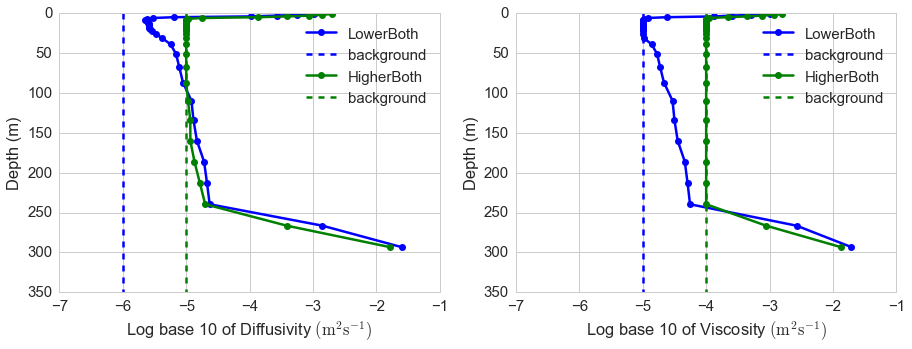

In [31]:
site='VENUS Central'
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig =compare_visc_diff(SITES[site]['i'], SITES[site]['j'],site, zmin=0, zmax=350,xmin=-7,xmax=-1)

# Sketch

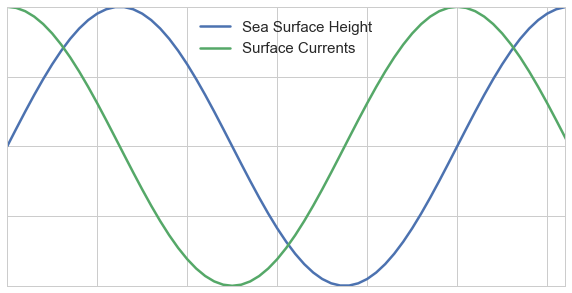

In [32]:
fs = 100 # sample rate 
f = 2 # the frequency of the signal

x = np.arange(fs) # the points on the x axis for plotting
# compute the value (amplitude) of the sin wave at the for each sample
y = [ np.sin(2*np.pi*f * (i/fs)) for i in np.arange(fs)]

y_cos  = [ np.cos(2*np.pi*f * (i/fs)) for i in np.arange(fs)]
# showing the exact location of the smaples
#plt.stem(x,y, 'r', )
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(x,y,label = 'Sea Surface Height')
ax.plot(x,y_cos,label = 'Surface Currents')
ax.set_xlim([0,62])
plt.setp( ax.get_xticklabels(), visible=False)
plt.setp( ax.get_yticklabels(), visible=False)
ax.legend(loc = 'best')

# River channel image

In [33]:
bathy_6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r' )
bathyy_6 = bathy_6.variables['Bathymetry']
lon_6 = bathy_6.variables['nav_lon']
lat_6 = bathy_6.variables['nav_lat']

In [34]:
bathy_2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc','r' )
bathyy_2 = bathy_2.variables['Bathymetry']
lon_2 = bathy_2.variables['nav_lon']
lat_2 = bathy_2.variables['nav_lat']

In [35]:
def plot_colourmesh(
    dataset,
    title,
    fig_size=(9, 9),
    axis_limits=None,
    colour_map='winter_r',
    bins=15,
    land_colour='#edc9af',
):
    """Create a colour-mesh plot of a bathymetry dataset
    on a longitude/latitude axis.

    :arg dataset: netcdf dataset object containing the bathymetry
    :type dataset: :py:class:`netCDF4.Dataset`

    :arg title: Title for the plot
    :type title: str

    :arg fig_size: Size of the figure
    :type fig_size: 2-tuple

    :arg axis_limits: Axis limits for the plt (xmin, xmax, ymin, ymax);
                      defaults to those calculated by :py:obj:`matplotlib`
    :type axis_limits: 4-tuple

    :arg colour_map: :py:obj:`matplotlib` colour map name
    :type colour_map: str

    :arg bins: Number of level bins for the colour map
    :type bins: int

    :arg land_colour: Colour to use for land regions;
                      i.e. those which the depth is undefined in the
                      dataset's :py:const:`Bathymetry` variable masked array
    :type land_colour: str

    :returns: Figure object containing the plot
    :rtype: :py:class:`matplotlib.figure.Figure`
    """
    lats = dataset.variables['nav_lat']
    lons = dataset.variables['nav_lon']
    depths = dataset.variables['Bathymetry']
    fig = plt.figure(figsize=fig_size)
    bathy_tools.set_aspect_ratio(lats)
    
    cmap, norm = bathy_tools.prep_colour_map(
        depths, limits=(0, np.max(depths)), colour_map=colour_map, bins=bins)
    cmap.set_bad(land_colour)
    plt.pcolormesh(lons[:], lats[:], depths[:], cmap=cmap, norm=norm)
    if axis_limits is not None:
        plt.axis(axis_limits)
    cbar = plt.colorbar(shrink=0.8, orientation = 'horizontal')
    cbar.set_label('Depth [m]')
    plt.xlabel('Longitude')
    plt.ylabel('Lattitude')
    return fig

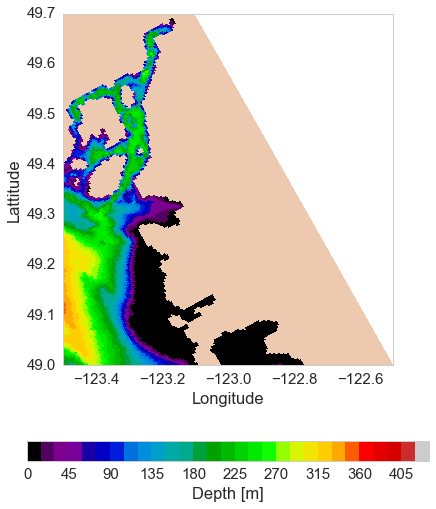

In [36]:
fig = plot_colourmesh(
    bathy_2,'',
    axis_limits=(-123.5, -122.5, 49., 49.7), colour_map='spectral', bins=30)

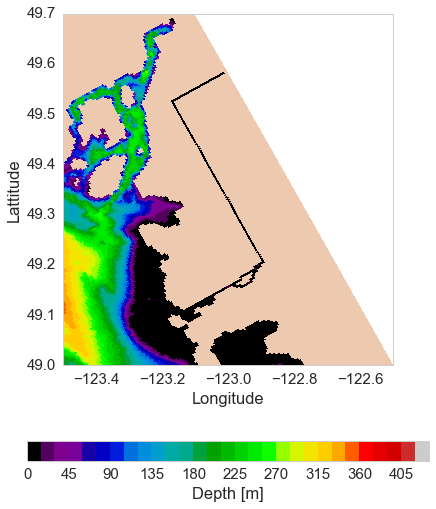

In [37]:
fig = plot_colourmesh(
    bathy_6,'',
    axis_limits=(-123.5, -122.5, 49., 49.7), colour_map='spectral', bins=30)